In [1]:
import torch
import os
import getpass
if getpass.getuser() == 'vscode':       # Running in container
    os.chdir('/workspaces/kornia/')
else:                                   # Running in virtual environment
    os.chdir(os.path.join(os.path.expanduser('~'), 'Documents/Git/kornia/'))
print(os.getcwd())

/home/yhollander/Documents/Git/kornia


In [2]:
from kornia.geometry.nerf.nerf_solver import NerfSolver
from torchvision.io import read_image
import matplotlib.pyplot as plt

torch.Size([756, 1008, 3])

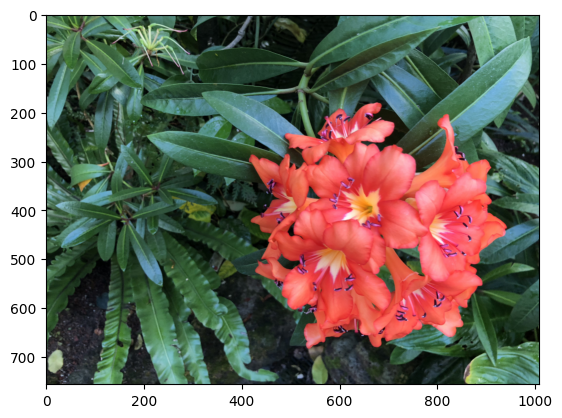

In [3]:
img = ['kornia/geometry/nerf/kornia_nerf_data/flower_4/images/image001.png']

img_plt = read_image(img[0])
img_plt = torch.permute(img_plt, (1, 2, 0))

plt.imshow(img_plt)
img_plt.shape

In [8]:
from kornia.geometry.camera import PinholeCamera
import math 

def create_intrinsics(fxs, fys, cxs, cys, device, dtype):
    intrinsics_batch = []
    for fx, fy, cx, cy in zip(fxs, fys, cxs, cys):
        intrinsics = torch.eye(4, device=device, dtype=dtype)
        intrinsics[0, 0] = fx
        intrinsics[1, 1] = fy
        intrinsics[0, 2] = cx
        intrinsics[1, 2] = cy
        intrinsics_batch.append(intrinsics)
    return torch.stack(intrinsics_batch)


def create_extrinsics_with_rotation(alphas, betas, gammas, txs, tys, tzs, device, dtype):
    extrinsics_batch = []
    for alpha, beta, gamma, tx, ty, tz in zip(alphas, betas, gammas, txs, tys, tzs):
        Rx = torch.eye(3, device=device, dtype=dtype)
        Rx[1, 1] = math.cos(alpha)
        Rx[1, 2] = math.sin(alpha)
        Rx[2, 1] = -Rx[1, 2]
        Rx[2, 2] = Rx[1, 1]

        Ry = torch.eye(3, device=device, dtype=dtype)
        Ry[0, 0] = math.cos(beta)
        Ry[0, 2] = -math.sin(beta)
        Ry[2, 0] = -Ry[0, 2]
        Ry[2, 2] = Ry[0, 0]

        Rz = torch.eye(3, device=device, dtype=dtype)
        Rz[0, 0] = math.cos(gamma)
        Rz[0, 1] = math.sin(gamma)
        Rz[1, 0] = -Rz[0, 1]
        Rz[1, 1] = Rz[0, 0]

        Ryz = torch.matmul(Ry, Rz)
        R = torch.matmul(Rx, Ryz)

        extrinsics = torch.eye(4, device=device, dtype=dtype)
        extrinsics[..., 0, -1] = tx
        extrinsics[..., 1, -1] = ty
        extrinsics[..., 2, -1] = tz
        extrinsics[:3, :3] = R

        extrinsics_batch.append(extrinsics)
    return torch.stack(extrinsics_batch)


def create_one_camera(height, width, device, dtype=torch.float32) -> PinholeCamera:
    fx = width
    fy = height
    cx = (width - 1.0) / 2.0
    cy = (height - 1.0) / 2.0

    tx = 0.0
    ty = 0.0
    tz = 1.0

    alpha = torch.pi / 2.0
    beta = 0.0
    gamma = -torch.pi / 2.0

    intrinsics = create_intrinsics([fx], [fy], [cx], [cy], device=device, dtype=dtype)
    extrinsics = create_extrinsics_with_rotation([alpha], [beta], [gamma], [tx], [ty], [tz], device=device, dtype=dtype)

    return PinholeCamera(
        intrinsics,
        extrinsics,
        torch.tensor([height], device=device, dtype=dtype),
        torch.tensor([width], device=device, dtype=dtype),
    )


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cameras = create_one_camera(img_plt.shape[0], img_plt.shape[1], device)

nerf_obj = NerfSolver(device=device)
num_img_rays = 1024
nerf_obj.init_training(cameras=cameras, min_depth=0., max_depth=3., imgs=img, num_img_rays=num_img_rays, 
                       batch_size=num_img_rays, num_ray_points=101)

#, 0.0, 3.0, img, num_img_rays, 32, 101, lr=1.e-2)
nerf_obj.run(num_epochs=20000)

cuda
Epoch: 0: epoch_loss = 0.17416062951087952
Epoch: 1: epoch_loss = 0.037311241030693054
Epoch: 2: epoch_loss = 0.030635785311460495
Epoch: 3: epoch_loss = 0.03473837673664093
Epoch: 4: epoch_loss = 0.036907270550727844
Epoch: 5: epoch_loss = 0.03801017627120018
Epoch: 6: epoch_loss = 0.03186599537730217
Epoch: 7: epoch_loss = 0.034414052963256836
Epoch: 8: epoch_loss = 0.02938871644437313
Epoch: 9: epoch_loss = 0.03156082332134247
Epoch: 10: epoch_loss = 0.027661751955747604
Epoch: 11: epoch_loss = 0.028084855526685715
Epoch: 12: epoch_loss = 0.029546011239290237
Epoch: 13: epoch_loss = 0.027561694383621216
Epoch: 14: epoch_loss = 0.02785305678844452
Epoch: 15: epoch_loss = 0.028194457292556763
Epoch: 16: epoch_loss = 0.029177788645029068
Epoch: 17: epoch_loss = 0.03190523386001587
Epoch: 18: epoch_loss = 0.031070610508322716
Epoch: 19: epoch_loss = 0.030362606048583984
Epoch: 20: epoch_loss = 0.029590031132102013
Epoch: 21: epoch_loss = 0.026387739926576614
Epoch: 22: epoch_loss =

KeyboardInterrupt: 

In [10]:
img_rendered = nerf_obj.render_views(cameras)[0]
img_rendered_plt = torch.permute(img_rendered, (1, 2, 0))

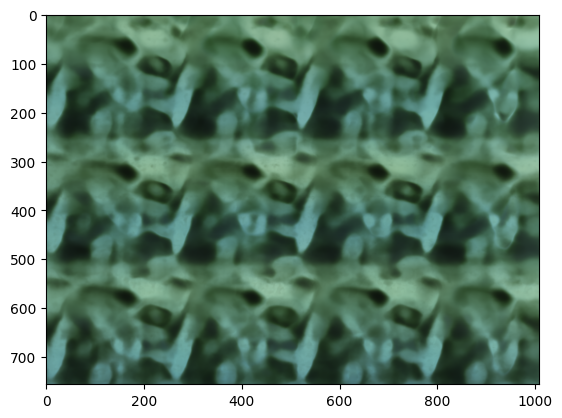

In [11]:
plt.imshow(img_rendered_plt)